In [1]:
pip install category_encoders


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.4 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## USING DIFFERENT ARCHITECTURE

In [2]:
import pandas as pd

In [4]:
df=pd.read_csv("/content/drive/MyDrive/final_category.csv")

In [5]:
df.shape

(75000, 14)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sample_id                  75000 non-null  int64  
 1   catalog_content            75000 non-null  object 
 2   unit                       75000 non-null  object 
 3   unit_qty                   75000 non-null  float64
 4   pack_count                 75000 non-null  int64  
 5   total_qty                  75000 non-null  float64
 6   num_bullet_points          75000 non-null  float64
 7   num_product_desc           75000 non-null  float64
 8   total_chars_bullet_points  75000 non-null  float64
 9   total_chars_product_desc   75000 non-null  float64
 10  avg_bullet_point_len       75000 non-null  float64
 11  price                      75000 non-null  float64
 12  brand_name                 75000 non-null  object 
 13  category                   75000 non-null  obj

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sentence_transformers import SentenceTransformer
import joblib

numeric_features = [
    'unit_qty', 'pack_count', 'total_qty',
    'num_bullet_points', 'num_product_desc',
    'total_chars_bullet_points', 'total_chars_product_desc', 'avg_bullet_point_len'
]

categorical_features = ['unit', 'brand_name',"category"]
text_feature = 'catalog_content'


def build_preprocessor():
    return ColumnTransformer(transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', TargetEncoder(cols=categorical_features, handle_unknown='impute'), categorical_features)
    ])


def generate_text_embeddings(df, model_name='stsb-roberta-base', batch_size=128, device='cuda'):
    model = SentenceTransformer(model_name, device=device)
    texts = df[text_feature].astype(str).tolist()
    embeddings = model.encode(texts, batch_size=batch_size, show_progress_bar=True, device=device)
    return np.array(embeddings)


def process_catalog_df(df, target_col='price', test=False, pipeline_path='process_pipeline.pkl', model_name='stsb-roberta-base'):
    if not test:
        preprocessor = build_preprocessor()
        X_non_text = df[numeric_features + categorical_features]
        y = df[target_col]
        preprocessor.fit(X_non_text, y)
        joblib.dump(preprocessor, pipeline_path)
        print(f"Non-text pipeline saved to {pipeline_path}")
    else:
        preprocessor = joblib.load(pipeline_path)
        print(f"Non-text pipeline loaded from {pipeline_path}")

    X_non_text_processed = preprocessor.transform(df[numeric_features + categorical_features])

    text_embeddings = generate_text_embeddings(df, model_name=model_name)

    X_processed = np.hstack((X_non_text_processed, text_embeddings))
    return X_processed


X_train = process_catalog_df(df, target_col='price', test=False)
# X_test = process_catalog_df(test_data, target_col='price', test=True)



Non-text pipeline saved to process_pipeline.pkl


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/672 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/586 [00:00<?, ?it/s]

In [8]:
Y_train=df["price"]

In [9]:
print("X train shape:", X_train.shape)
print("Y train shape:", Y_train.shape)


X train shape: (75000, 779)
Y train shape: (75000,)


In [10]:
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
Y_train = np.nan_to_num(Y_train, nan=0.0, posinf=0.0, neginf=0.0)


In [12]:
np.save("features_75k_779.npy", X_train)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.saving import register_keras_serializable

@tf.keras.saving.register_keras_serializable()
def smape_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    numerator = tf.abs(y_true - y_pred)
    denominator = tf.maximum((tf.abs(y_true) + tf.abs(y_pred)) / 2.0, 1e-3)
    smape = numerator / denominator
    smape = tf.where(tf.math.is_finite(smape), smape, tf.zeros_like(smape))
    return tf.reduce_mean(smape)


def build_optimized_mlp(input_dim):
    model = Sequential([
        Dense(512, input_dim=input_dim),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),

        Dense(256),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.25),

        Dense(128),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),

        Dense(64, activation='relu'),
        Dropout(0.15),

        Dense(1, activation='linear')
    ])

    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss=smape_loss, metrics=['mae'])
    return model


callbacks = [
    ModelCheckpoint('best_mlp_smape_model.h5', monitor='val_loss', save_best_only=True, verbose=1),

]

# ✅ Build and train
input_dim = X_train.shape[1]
model = build_optimized_mlp(input_dim)

history = model.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

# ✅ Evaluate
best_model = tf.keras.models.load_model('best_mlp_smape_model.h5', custom_objects={'smape_loss': smape_loss})
# loss, mae = best_model.evaluate(X_test, Y_test, verbose=0)
# print(f"✅ Best Model SMAPE: {loss:.4f}, MAE: {mae:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6670 - mae: 13.9203
Epoch 1: val_loss improved from inf to 0.72041, saving model to best_mlp_smape_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.6667 - mae: 13.9162 - val_loss: 0.7204 - val_mae: 17.1030
Epoch 2/100
459/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4585 - mae: 10.5418
Epoch 2: val_loss improved from 0.72041 to 0.57717, saving model to best_mlp_smape_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4585 - mae: 10.5385 - val_loss: 0.5772 - val_mae: 13.3339
Epoch 3/100
460/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4430 - mae: 10.1698
Epoch 3: val_loss improved from 0.57717 to 0.52014, saving model to best_mlp_smape_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4429 - mae: 10.1673 - val_loss: 0.5201 - val_mae: 11.3218
Epoch 4/100
456/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4328 - mae: 9.9182
Epoch 4: val_loss improved from 0.52014 to 0.43485, saving model to best_mlp_smape_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4328 - mae: 9.9176 - val_loss: 0.4348 - val_mae: 9.6313
Epoch 5/100
456/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4234 - mae: 9.6519
Epoch 5: val_loss did not improve from 0.43485
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4234 - mae: 9.6529 - val_loss: 0.4414 - val_mae: 9.6418
Epoch 6/100
460/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4193 - mae: 9.6843
Epoch 6: val_loss did not improve from 0.43485
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4193 - mae: 9.6821 - val_loss: 0.4371 - val_mae: 9.3912
Epoch 7/100
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4163 - mae: 9.6228
Epoch 7: val_loss improved from 0.43485 to 0.39562, saving model to best_mlp_smape_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4163 - mae: 9.6207 - val_loss: 0.3956 - val_mae: 8.8388
Epoch 8/100
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4076 - mae: 9.5985
Epoch 8: val_loss did not improve from 0.39562
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4076 - mae: 9.5962 - val_loss: 0.4005 - val_mae: 8.7965
Epoch 9/100
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4055 - mae: 9.3729
Epoch 9: val_loss improved from 0.39562 to 0.36716, saving model to best_mlp_smape_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4055 - mae: 9.3719 - val_loss: 0.3672 - val_mae: 8.4123
Epoch 10/100
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4047 - mae: 9.1462
Epoch 10: val_loss did not improve from 0.36716
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4047 - mae: 9.1484 - val_loss: 0.3785 - val_mae: 8.5650
Epoch 11/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3985 - mae: 9.1418
Epoch 11: val_loss did not improve from 0.36716
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3985 - mae: 9.1418 - val_loss: 0.3800 - val_mae: 8.6274
Epoch 12/100
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3975 - mae: 9.1297
Epoch 12: val_loss did not improve from 0.36716
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3975 - mae: 9.1307 - val_loss: 0.3753 - val_mae: 8.3941
Epoch 13/100
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3968 - mae: 9.1783
Epoch 13: val_loss did not improve from 0.36716
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss:

469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3882 - mae: 8.9784 - val_loss: 0.3588 - val_mae: 8.1565
Epoch 17/100
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3863 - mae: 8.8575
Epoch 17: val_loss improved from 0.35883 to 0.35869, saving model to best_mlp_smape_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3863 - mae: 8.8584 - val_loss: 0.3587 - val_mae: 8.1083
Epoch 18/100
457/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3840 - mae: 8.7657
Epoch 18: val_loss did not improve from 0.35869
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3841 - mae: 8.7693 - val_loss: 0.3600 - val_mae: 8.0939
Epoch 19/100
459/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3819 - mae: 8.7719
Epoch 19: val_loss improved from 0.35869 to 0.35741, saving model to best_mlp_smape_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3820 - mae: 8.7734 - val_loss: 0.3574 - val_mae: 8.1051
Epoch 20/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3805 - mae: 8.7140
Epoch 20: val_loss improved from 0.35741 to 0.35375, saving model to best_mlp_smape_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3805 - mae: 8.7142 - val_loss: 0.3537 - val_mae: 8.0651
Epoch 21/100
456/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3811 - mae: 8.7963
Epoch 21: val_loss did not improve from 0.35375
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3811 - mae: 8.7956 - val_loss: 0.3584 - val_mae: 8.1796
Epoch 22/100
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3799 - mae: 8.6832
Epoch 22: val_loss did not improve from 0.35375
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3799 - mae: 8.6846 - val_loss: 0.3627 - val_mae: 8.1827
Epoch 23/100
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3763 - mae: 8.7895
Epoch 23: val_loss did not improve from 0.35375
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3763 - mae: 8.7883 - val_loss: 0.3545 - val_mae: 7.9944
Epoch 24/100
461/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3713 - mae: 8.3118
Epoch 24: val_loss did not improve from 0.35375
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss:

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3681 - mae: 8.5569 - val_loss: 0.3491 - val_mae: 7.8852
Epoch 29/100
453/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3663 - mae: 8.5123
Epoch 29: val_loss did not improve from 0.34914
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3664 - mae: 8.5139 - val_loss: 0.3549 - val_mae: 7.9046
Epoch 30/100
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3653 - mae: 8.4827
Epoch 30: val_loss did not improve from 0.34914
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3653 - mae: 8.4829 - val_loss: 0.3521 - val_mae: 8.0742
Epoch 31/100
461/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3629 - mae: 8.5032
Epoch 31: val_loss did not improve from 0.34914
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3630 - mae: 8.5027 - val_loss: 0.3712 - val_mae: 8.2468
Epoch 32/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3635 - mae: 8.3573
Epoch 32: val_loss did not improve from 0.34914
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss:

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3571 - mae: 8.2834 - val_loss: 0.3459 - val_mae: 7.7892
Epoch 36/100
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3573 - mae: 8.2346
Epoch 36: val_loss did not improve from 0.34586
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3573 - mae: 8.2351 - val_loss: 0.3686 - val_mae: 8.4101
Epoch 37/100
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3563 - mae: 8.3455
Epoch 37: val_loss did not improve from 0.34586
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3564 - mae: 8.3451 - val_loss: 0.3570 - val_mae: 8.3075
Epoch 38/100
460/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3587 - mae: 8.4085
Epoch 38: val_loss did not improve from 0.34586
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3587 - mae: 8.4074 - val_loss: 0.3485 - val_mae: 7.9854
Epoch 39/100
454/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3588 - mae: 8.4279
Epoch 39: val_loss did not improve from 0.34586
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss:

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3546 - mae: 8.1318 - val_loss: 0.3444 - val_mae: 7.8155
Epoch 41/100
459/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3514 - mae: 8.0146
Epoch 41: val_loss did not improve from 0.34439
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3515 - mae: 8.0207 - val_loss: 0.3486 - val_mae: 8.0488
Epoch 42/100
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3521 - mae: 8.1635
Epoch 42: val_loss did not improve from 0.34439
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3521 - mae: 8.1637 - val_loss: 0.3552 - val_mae: 8.2363
Epoch 43/100
460/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3482 - mae: 7.9816
Epoch 43: val_loss improved from 0.34439 to 0.34328, saving model to best_mlp_smape_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3483 - mae: 7.9864 - val_loss: 0.3433 - val_mae: 7.7393
Epoch 44/100
458/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3511 - mae: 8.2217
Epoch 44: val_loss did not improve from 0.34328
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3511 - mae: 8.2222 - val_loss: 0.3497 - val_mae: 7.9459
Epoch 45/100
461/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3512 - mae: 8.1571
Epoch 45: val_loss did not improve from 0.34328
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3513 - mae: 8.1573 - val_loss: 0.3540 - val_mae: 7.9323
Epoch 46/100
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3515 - mae: 8.2888
Epoch 46: val_loss did not improve from 0.34328
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3515 - mae: 8.2879 - val_loss: 0.3463 - val_mae: 7.9042
Epoch 47/100
454/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3456 - mae: 7.8691
Epoch 47: val_loss did not improve from 0.34328
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss:

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3398 - mae: 8.0191 - val_loss: 0.3426 - val_mae: 7.7755
Epoch 62/100
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3371 - mae: 7.7480
Epoch 62: val_loss did not improve from 0.34264
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3371 - mae: 7.7502 - val_loss: 0.3542 - val_mae: 8.0213
Epoch 63/100
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3377 - mae: 7.8532
Epoch 63: val_loss did not improve from 0.34264
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3377 - mae: 7.8543 - val_loss: 0.3582 - val_mae: 8.1643
Epoch 64/100
456/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3362 - mae: 7.8750
Epoch 64: val_loss did not improve from 0.34264
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3363 - mae: 7.8746 - val_loss: 0.3438 - val_mae: 7.7810
Epoch 65/100
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3403 - mae: 7.8385
Epoch 65: val_loss did not improve from 0.34264
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss:

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3393 - mae: 7.8248 - val_loss: 0.3419 - val_mae: 7.7105
Epoch 67/100
455/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3351 - mae: 7.8548
Epoch 67: val_loss did not improve from 0.34188
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3351 - mae: 7.8532 - val_loss: 0.3675 - val_mae: 8.6246
Epoch 68/100
452/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3342 - mae: 7.7769
Epoch 68: val_loss did not improve from 0.34188
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3342 - mae: 7.7776 - val_loss: 0.3549 - val_mae: 8.2606
Epoch 69/100
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3292 - mae: 7.5347
Epoch 69: val_loss improved from 0.34188 to 0.34182, saving model to best_mlp_smape_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3292 - mae: 7.5365 - val_loss: 0.3418 - val_mae: 7.7164
Epoch 70/100
453/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3352 - mae: 7.7907
Epoch 70: val_loss did not improve from 0.34182
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3352 - mae: 7.7915 - val_loss: 0.3512 - val_mae: 8.0655
Epoch 71/100
454/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3366 - mae: 7.8945
Epoch 71: val_loss improved from 0.34182 to 0.34138, saving model to best_mlp_smape_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3365 - mae: 7.8897 - val_loss: 0.3414 - val_mae: 7.6616
Epoch 72/100
459/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3343 - mae: 7.7657
Epoch 72: val_loss did not improve from 0.34138
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3343 - mae: 7.7657 - val_loss: 0.3436 - val_mae: 7.8080
Epoch 73/100
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3317 - mae: 7.6426
Epoch 73: val_loss did not improve from 0.34138
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3317 - mae: 7.6429 - val_loss: 0.3433 - val_mae: 7.7911
Epoch 74/100
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3326 - mae: 7.7215
Epoch 74: val_loss did not improve from 0.34138
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3326 - mae: 7.7216 - val_loss: 0.3493 - val_mae: 7.9823
Epoch 75/100
457/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3301 - mae: 7.6605
Epoch 75: val_loss did not improve from 0.34138
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss:

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3300 - mae: 7.6837 - val_loss: 0.3399 - val_mae: 7.7234
Epoch 80/100
455/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3307 - mae: 7.7350
Epoch 80: val_loss did not improve from 0.33986
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3307 - mae: 7.7345 - val_loss: 0.3511 - val_mae: 7.9782
Epoch 81/100
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3255 - mae: 7.6443
Epoch 81: val_loss did not improve from 0.33986
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3255 - mae: 7.6441 - val_loss: 0.3495 - val_mae: 7.8714
Epoch 82/100
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3267 - mae: 7.5895
Epoch 82: val_loss did not improve from 0.33986
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3267 - mae: 7.5899 - val_loss: 0.3551 - val_mae: 7.8949
Epoch 83/100
459/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3239 - mae: 7.5147
Epoch 83: val_loss did not improve from 0.33986
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss:

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sample_id                  75000 non-null  int64  
 1   catalog_content            75000 non-null  object 
 2   unit                       75000 non-null  object 
 3   unit_qty                   75000 non-null  float64
 4   pack_count                 75000 non-null  int64  
 5   total_qty                  75000 non-null  float64
 6   num_bullet_points          75000 non-null  float64
 7   num_product_desc           75000 non-null  float64
 8   total_chars_bullet_points  75000 non-null  float64
 9   total_chars_product_desc   75000 non-null  float64
 10  avg_bullet_point_len       75000 non-null  float64
 11  price                      75000 non-null  float64
 12  brand_name                 75000 non-null  object 
 13  category                   75000 non-null  obj

In [31]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots training and validation metrics from a Keras model history.
    """
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, linestyle='--')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    metric_keys = [k for k in history.history.keys() if 'mae' in k.lower()]
    if metric_keys:
        plt.subplot(1, 2, 2)
        plt.plot(history.history[metric_keys[0]], label='Train MAE', linewidth=2)
        val_metric = [k for k in metric_keys if k.startswith('val_')]
        if val_metric:
            plt.plot(history.history[val_metric[0]], label='Validation MAE', linewidth=2, linestyle='--')
        plt.title('Model MAE Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


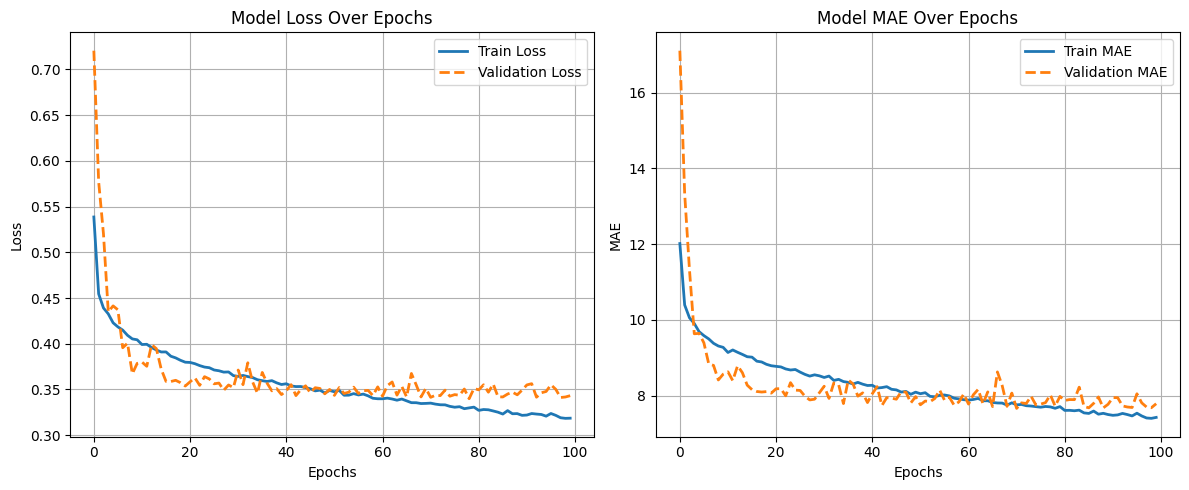

In [32]:
plot_training_history(history)

## EVALUATION ON TEST DATA

In [ ]:

import pandas as pd
test_df=pd.read_csv("/content/drive/MyDrive/final_test_with_category.csv")
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sentence_transformers import SentenceTransformer
import joblib

numeric_features = [
    'unit_qty', 'pack_count', 'total_qty',
    'num_bullet_points', 'num_product_desc',
    'total_chars_bullet_points', 'total_chars_product_desc', 'avg_bullet_point_len'
]

categorical_features = ['unit', 'brand_name',"category"]
text_feature = 'catalog_content'


def build_preprocessor():
    return ColumnTransformer(transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', TargetEncoder(cols=categorical_features, handle_unknown='impute'), categorical_features)
    ])


def generate_text_embeddings(df, model_name='stsb-roberta-base', batch_size=128, device='cuda'):
    model = SentenceTransformer(model_name, device=device)
    texts = df[text_feature].astype(str).tolist()
    embeddings = model.encode(texts, batch_size=batch_size, show_progress_bar=True, device=device)
    return np.array(embeddings)


def process_catalog_df(df, target_col='price', test=False, pipeline_path='process_pipeline.pkl', model_name='stsb-roberta-base'):
    if not test:
        preprocessor = build_preprocessor()
        X_non_text = df[numeric_features + categorical_features]
        preprocessor.fit(X_non_text)
        joblib.dump(preprocessor, pipeline_path)
        print(f"Non-text pipeline saved to {pipeline_path}")
    else:
        preprocessor = joblib.load(pipeline_path)
        print(f"Non-text pipeline loaded from {pipeline_path}")

    X_non_text_processed = preprocessor.transform(df[numeric_features + categorical_features])

    text_embeddings = generate_text_embeddings(df, model_name=model_name)

    X_processed = np.hstack((X_non_text_processed, text_embeddings))
    return X_processed


# X_train = process_catalog_df(train_data, target_col='price', test=False)
X_test = process_catalog_df(test_df, target_col='price', test=True)


np.save("features_75k_779_test.npy", X_test)
X_test.shape
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

y_pred=model.predict(X_test)
print(np.isnan(y_pred).sum())
test_df["sample_id"].values
pd.DataFrame(y_pred)
test_out=pd.DataFrame({"sample_id":test_df["sample_id"].values,"price":y_pred.flatten()})
test_out.isnull().sum()
test_out.to_csv("test_out.csv",index=False)
